# Building Generative AI Agents with the Agent Development Kit (ADK)

## Overview

This notebook guides you through building a conversational AI agent, using the Agent Development Kit (ADK). We'll start with a simple agent that looks up weather information and progressively add more sophisticated features like sub-agent delegation for handling different types of user requests and session state for memory and personalization. <br>
Throughout this tutorial, you'll also learn how to use the ADK Developer UI to inspect and debug your agents.

## Learning Goals

By the end of this notebook, you will understand how to:
* Create and configure **Agents**, using **Tools**, and **Sub-Agents**.
* Use the ADK **Runner** and **SessionService** to manage and execute agent interactions.
* Set up and use the **ADK Developer UI** for inspecting agent behavior, including tool calls and event flows.
* Implement **Session State** to provide agents with memory, enabling context-aware and personalized conversations.

## Setup
This lab needs a special kernel to run, please run the following cell. 

In [ ]:
!echo "Kernel installation started."
!cd ../../.. && make adk_kernel > /dev/null 2>&1
!echo "Kernel installation completed."

When it's completed, select the **`ADK Kernel`** on the top right before going forward in the notebook.<br>
It may take ~1 minutes until the kernel is shown after the installation.

## Install Packages

In [ ]:
import asyncio
import importlib
import os
import warnings

from google.adk.agents import Agent
from google.adk.models.lite_llm import LiteLlm  # For multi-model support
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools.tool_context import ToolContext
from google.genai import types  # For creating message Content/Parts
from IPython.display import HTML, Markdown, display

# Ignore all warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(level=logging.ERROR)

In [ ]:
LOCATION = "us-central1"
os.environ["GOOGLE_CLOUD_LOCATION"] = LOCATION
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "TRUE"  # Use Vertex AI API

In [ ]:
%%bash
echo > adk_agents/.env "GOOGLE_CLOUD_LOCATION=$GOOGLE_CLOUD_LOCATION
GOOGLE_GENAI_USE_VERTEXAI=$GOOGLE_GENAI_USE_VERTEXAI
"

In [ ]:
MODEL = "gemini-2.0-flash"

## Basic App: Weather Lookup

Let's begin by building the fundamental component of our Weather Bot: a single agent capable of performing a specific task – looking up weather information. This involves creating two core pieces:

- A Tool: A Python function that equips the agent with the ability to fetch weather data.
- An Agent: The AI "brain" that understands the user's request, knows it has a weather tool, and decides when and how to use it.

### Define the Tool (get_weather)

In ADK, **Tools** are the building blocks that give agents concrete capabilities beyond just text generation. They are typically regular Python functions that perform specific actions, like calling an API, querying a database, or performing calculations.

Our first tool will provide a *mock* weather report. This allows us to focus on the agent structure without needing external API keys yet. Later, you could easily swap this mock function with one that calls a real weather service.

**Key Concept: Docstrings are Crucial\!** The agent's LLM relies heavily on the function's **docstring** to understand:

* *What* the tool does.  
* *When* to use it.  
* *What arguments* it requires (`city: str`).  
* *What information* it returns.

**Best Practice:** Write clear, descriptive, and accurate docstrings for your tools. This is essential for the LLM to use the tool correctly.

In [ ]:
%%writefile ./adk_agents/agent1_weather_lookup/tools.py
def get_weather(city: str) -> dict:
    """Retrieves the current weather report for a specified city.

    Args:
        city (str): The name of the city (e.g., "New York", "London", "Tokyo").

    Returns:
        dict: A dictionary containing the weather information.
              Includes a 'status' key ('success' or 'error').
              If 'success', includes a 'report' key with weather details.
              If 'error', includes an 'error_message' key.
    """
    print(f"--- Tool: get_weather called for city: {city} ---") # Log tool execution
    city_normalized = city.lower().replace(" ", "") # Basic normalization

    # Mock weather data
    mock_weather_db = {
        "newyork": {"status": "success", "report": "The weather in New York is sunny with a temperature of 25°C."},
        "london": {"status": "success", "report": "It's cloudy in London with a temperature of 15°C."},
        "tokyo": {"status": "success", "report": "Tokyo is experiencing light rain and a temperature of 18°C."},
    }

    if city_normalized in mock_weather_db:
        return mock_weather_db[city_normalized]
    else:
        return {"status": "error", "error_message": f"Sorry, I don't have weather information for '{city}'."}

### Define the Agent (`weather_agent`)

Now, let's create the **Agent** itself. An `Agent` in ADK orchestrates the interaction between the user, the LLM, and the available tools.

We configure it with several key parameters:

* `name`: A unique identifier for this agent (e.g., "weather\_agent\_v1").  
* `model`: Specifies which LLM to use (e.g., `gemini-2.0-flash`).
* `description`: A concise summary of the agent's overall purpose. This becomes crucial later when other agents need to decide whether to delegate tasks to *this* agent.  
* `instruction`: Detailed guidance for the LLM on how to behave, its persona, its goals, and specifically *how and when* to utilize its assigned `tools`.  
* `tools`: A list containing the actual Python tool functions the agent is allowed to use (e.g., `[get_weather]`).

**Best Practices:** 
- Choose descriptive `name` and `description` values. These are used internally by ADK and are vital for features like automatic delegation (covered later).
- Provide clear and specific `instruction` prompts. The more detailed the instructions, the better the LLM can understand its role and how to use its tools effectively. Be explicit about error handling if needed.

In [ ]:
%%writefile ./adk_agents/agent1_weather_lookup/agent.py
from google.adk.agents import Agent
MODEL = "gemini-2.0-flash"

from .tools import get_weather

root_agent = Agent(
    name="weather_agent_v1",
    model=MODEL, # Can be a string for Gemini or a LiteLlm object
    description="Provides weather information for specific cities.",
    instruction="You are a helpful weather assistant. "
                "When the user asks for the weather in a specific city, "
                "use the 'get_weather' tool to find the information. "
                "If the tool returns an error, inform the user politely. "
                "If the tool is successful, present the weather report clearly.",
    tools=[get_weather], # Pass the function directly
)

In [ ]:
from adk_agents.agent1_weather_lookup import agent

importlib.reload(agent)  # Force reload

# Example tool usage (optional test)
print(agent.get_weather("New York"))
print(agent.get_weather("Paris"))

### Setup Runner and Session Service

To manage conversations and execute the agent, we need two more components:

* `SessionService`: Responsible for managing conversation history and state for different users and sessions. The `InMemorySessionService` is a simple implementation that stores everything in memory, suitable for testing and simple applications. It keeps track of the messages exchanged. We'll explore state persistence more in Step 4\.  
* `Runner`: The engine that orchestrates the interaction flow. It takes user input, routes it to the appropriate agent, manages calls to the LLM and tools based on the agent's logic, handles session updates via the `SessionService`, and yields events representing the progress of the interaction.

Let's define some constants first.

In [ ]:
APP_NAME = "weather_tutorial_app"
USER_ID = "user_1"
SESSION_ID = "session_001"  # Using a fixed ID for simplicity

#### Session

In [ ]:
session_service = InMemorySessionService()

# Create the specific session where the conversation will happen
session = await session_service.create_session(
    app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
)

#### Runner
Key Concept: Runner orchestrates the agent execution loop.

In [ ]:
runner = Runner(
    agent=agent.root_agent,  # The agent we want to run
    app_name=APP_NAME,  # Associates runs with our app
    session_service=session_service,  # Uses our session manager
)

### Interact with the Agent

We need a way to send messages to our agent and receive its responses. Since LLM calls and tool executions can take time, ADK's `Runner` operates asynchronously.

We'll define an `async` helper function (`call_agent_async`) that:

1. Takes a user query string.  
2. Packages it into the ADK `Content` format.  
3. Calls `runner.run_async`, providing the user/session context and the new message.  
4. Iterates through the **Events** yielded by the runner. Events represent steps in the agent's execution (e.g., tool call requested, tool result received, intermediate LLM thought, final response).  
5. Identifies and prints the **final response** event using `event.is_final_response()`.

**Why `async`?** Interactions with LLMs and potentially tools (like external APIs) are I/O-bound operations. Using `asyncio` allows the program to handle these operations efficiently without blocking execution.

In [ ]:
async def call_agent_async(query: str, runner, user_id, session_id):
    """Sends a query to the agent and prints the final response."""
    print(f"\n>>> User Query: {query}")

    content = types.Content(role="user", parts=[types.Part(text=query)])

    final_response_text = "Agent did not produce a final response."  # Default

    # Key Concept: run_async executes the agent logic and yields Events.
    # We iterate through events to find the final answer.
    async for event in runner.run_async(
        user_id=user_id, session_id=session_id, new_message=content
    ):
        # You can uncomment the line below to see *all* events during execution
        # print(f"  [Event] Author: {event.author}, Type: {type(event).__name__}, Final: {event.is_final_response()}, Content: {event.content}")

        # Key Concept: is_final_response() marks the concluding message for the turn.
        if event.is_final_response():
            if event.content and event.content.parts:
                # Assuming text response in the first part
                final_response_text = event.content.parts[0].text
            elif (
                event.actions and event.actions.escalate
            ):  # Handle potential errors/escalations
                final_response_text = f"Agent escalated: {event.error_message or 'No specific message.'}"
            # Add more checks here if needed (e.g., specific error codes)
            break  # Stop processing events once the final response is found

    print(f"<<< Agent Response: {final_response_text}")

### Run the Conversation

Finally, let's test our setup by sending a few queries to the agent. We wrap our `async` calls in a main `async` function and run it using `await`.

Watch the output:

* See the user queries.  
* Notice the `--- Tool: get_weather called... ---` logs when the agent uses the tool.  
* Observe the agent's final responses, including how it handles the case where weather data isn't available (for Paris).

In [ ]:
await call_agent_async(
    "What is the weather like in London?",
    runner=runner,
    user_id=USER_ID,
    session_id=SESSION_ID,
)

In [ ]:
await call_agent_async(
    "How about Paris?", runner=runner, user_id=USER_ID, session_id=SESSION_ID
)  # Expecting the tool's error message

In [ ]:
await call_agent_async(
    "Tell me the weather in New York",
    runner=runner,
    user_id=USER_ID,
    session_id=SESSION_ID,
)

In [ ]:
await call_agent_async(
    "What did I ask?", runner=runner, user_id=USER_ID, session_id=SESSION_ID
)

### Open the ADK Developer UI

1. Run this cell and check the passcode (public IP address) for localtunnel.

In [ ]:
!curl https://loca.lt/mytunnelpassword

2. Run the cell below and check the ADK UI on the URL created above.

In [ ]:
!adk web adk_agents

3. Open the terminal and run these commands to install, and open a localtunnel.

```bash
npm install -g localtunnel
lt --port 8000
```

4. Provide the passcode shown above (e.g.XXX.XXX.XXX.XXX), and open the ADK Developer UI.

### Use the Developer UI
Select `agent1_weather_lookup` on the top, and send queries referring to the conversation above.

You can see all the events (e.g., function calling, LLM responses) on the UI and check each object interactively.

Click `Interapt the kernel` button to terminate the process when you finished exploring the developer UI.

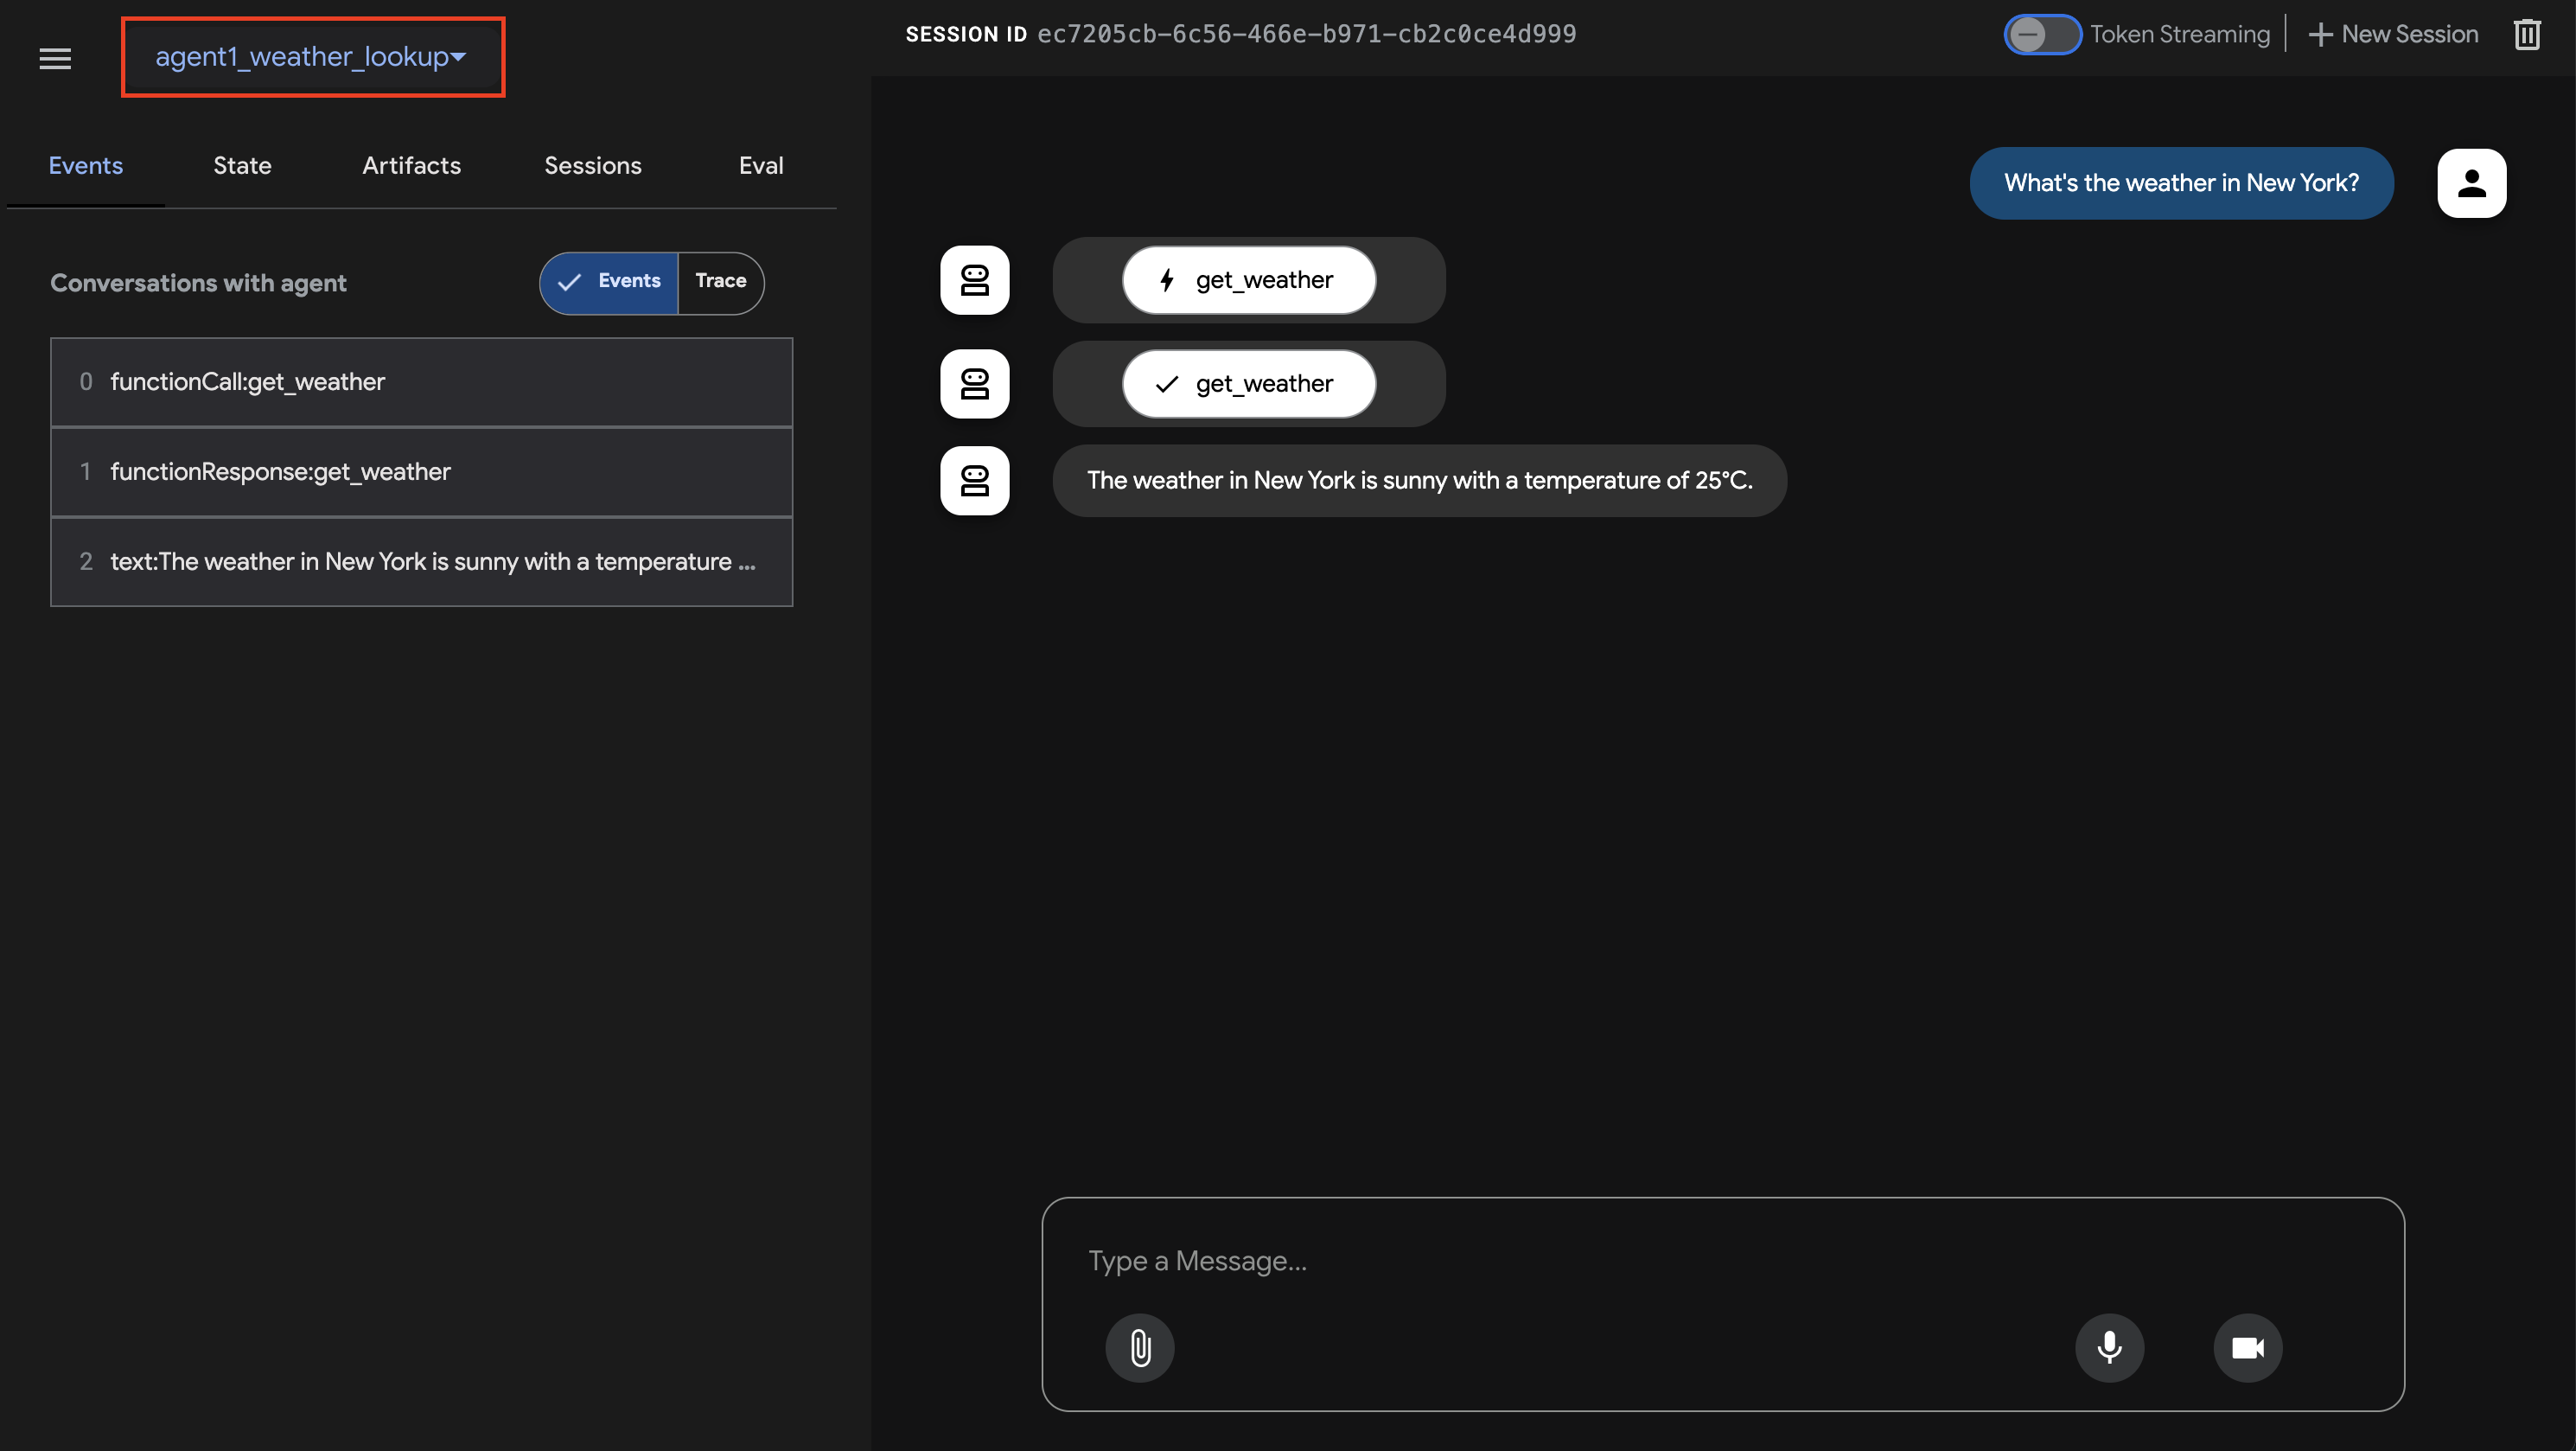

---
## Adding Complexity with Sub-Agents (Agent Teams)

In Step 1, we built and experimented with a single agent focused solely on weather lookups. While effective for its specific task, real-world applications often need to handle a wider variety of user interactions. We *could* continue adding more tools and increasingly complex instructions to our single weather agent, but this approach can quickly become unmanageable and less efficient.

A more robust and scalable approach is to build an **Agent Team**. This involves:

1.  Creating multiple **specialized sub-agents**, each designed for a specific capability (e.g., one for weather, one for greetings, one for calculations).
2.  Designating a **root agent** (also known as an orchestrator) that receives the initial user request.
3.  Enabling the root agent to **delegate** the request to the most appropriate specialized sub-agent based on the user's intent.

**Why build an Agent Team?**

* **Modularity:** Makes it easier to develop, test, and maintain individual agents.
* **Specialization:** Each agent can be fine-tuned (with specific instructions, different LLM models, or unique tools) for its particular task.
* **Scalability:** Simplifies adding new capabilities by just adding new specialized agents to the team.
* **Efficiency:** Allows for using potentially simpler or more cost-effective LLM models for simpler tasks (like handling greetings).

**In this step, we will:**

1.  Define simple tools for handling greetings (`say_hello`) and farewells (`say_goodbye`).
2.  Create two new specialized sub-agents: `greeting_agent` and `farewell_agent`.
3.  Update our main weather agent to `weather_agent_v2` to act as the **root agent**.
4.  Configure this root agent with its sub-agents, enabling **automatic delegation** (also known as Auto Flow in ADK).
5.  Test the delegation flow by sending different types of requests (greetings, weather queries, farewells) to the root agent.

### Define Tools for Sub-Agents

First, we'll copy the `get_weather` tool we created in Step 1 into the directory for our new agent team. 

We'll then add new tools for greetings and farewells to the same file.

In [ ]:
!cp ./adk_agents/agent1_weather_lookup/tools.py ./adk_agents/agent2_sub_agent/

Next, let's create the Python functions that will serve as tools for our new greeting and farewell specialist agents. Remember, clear and descriptive docstrings are vital for the LLMs of the agents that will use them.

In [ ]:
%%writefile -a ./adk_agents/agent2_sub_agent/tools.py

def say_hello(name: str = "there") -> str:
    """Provides a simple greeting, optionally addressing the user by name.

    Args:
        name (str, optional): The name of the person to greet. Defaults to "there".

    Returns:
        str: A friendly greeting message.
    """
    if name is None or name.strip() == "":
        name = "there"
    print(f"--- Tool: say_hello called with name: {name} ---")
    return f"Hello, {name}!"

def say_goodbye() -> str:
    """Provides a simple farewell message to conclude the conversation."""
    print(f"--- Tool: say_goodbye called ---")
    return "Goodbye! Have a great day."

In [ ]:
from adk_agents.agent2_sub_agent import tools

print(tools.say_hello("Alice"))
print(tools.say_goodbye())

### Define the Sub-Agents (Greeting & Farewell)

Now, we'll create the `Agent` instances for our specialist sub-agents. Notice their highly focused `instruction` prompts and, critically, their clear `description` fields. The `description` is the primary piece of information the *root agent's* LLM uses to determine *when* to delegate a task to one of these sub-agents.

**Best Practice:**
* A sub-agent's `description` field should accurately and concisely summarize its specific capability. This is crucial for effective automatic delegation.
* A sub-agent's `instruction` field should be tailored to its limited scope, telling it exactly what to do and, importantly, *what not* to do (e.g., "Your *only* task is to...").

In [ ]:
%%writefile ./adk_agents/agent2_sub_agent/agent.py
from google.adk.agents import Agent
MODEL = "gemini-2.0-flash"

from .tools import get_weather, say_hello, say_goodbye

# --- Greeting Agent ---
greeting_agent = Agent(
    model=MODEL,
    name="greeting_agent",
    instruction="You are the Greeting Agent. Your ONLY task is to provide a friendly greeting to the user. "
                "Use the 'say_hello' tool to generate the greeting. "
                "If the user provides their name, make sure to pass it to the tool. "
                "Do not engage in any other conversation or tasks.",
    description="Handles simple greetings and hellos using the 'say_hello' tool.", # Crucial for delegation
    tools=[say_hello],
)

In [ ]:
%%writefile -a ./adk_agents/agent2_sub_agent/agent.py

# --- Farewell Agent ---
farewell_agent = Agent(
    model=MODEL,
    name="farewell_agent",
    instruction="You are the Farewell Agent. Your ONLY task is to provide a polite goodbye message. "
                "Use the 'say_goodbye' tool when the user indicates they are leaving or ending the conversation "
                "(e.g., using words like 'bye', 'goodbye', 'thanks bye', 'see you'). "
                "Do not perform any other actions.",
    description="Handles simple farewells and goodbyes using the 'say_goodbye' tool.", # Crucial for delegation
    tools=[say_goodbye],
)

### Define the Root Agent (`weather_agent_v2`) with Sub-Agents

Now, we'll define `weather_agent_v2` to act as our root agent. The key changes from `weather_agent_v1` are:

* Adding the `sub_agents` parameter: We pass a list containing the `greeting_agent` and `farewell_agent` instances we just created.
* Updating the `instruction`: We explicitly tell the root agent *about* its sub-agents and *when* it should delegate tasks to them.

**Key Concept: Automatic Delegation (Auto Flow)**
By providing the `sub_agents` list to an agent, ADK enables automatic delegation. When the root agent (in this case, `weather_agent_v2`) receives a user query, its LLM considers not only its own instructions and tools but also the `description` of each sub-agent. If the LLM determines that a query aligns better with a sub-agent's described capability (e.g., the `greeting_agent`'s description: "Handles simple greetings..."), it will automatically generate a special internal action to *transfer control* to that sub-agent for that conversational turn. The chosen sub-agent then processes the query using its own LLM, instructions, and tools.

**Best Practice:** Ensure the root agent's instructions clearly guide its delegation decisions. Mention the sub-agents (often by `name`) and describe the conditions under which delegation to each should occur.

In [ ]:
%%writefile -a ./adk_agents/agent2_sub_agent/agent.py

root_agent = Agent(
    name="weather_agent_v2", # Give it a new version name
    model=MODEL,
    description="The main coordinator agent. Handles weather requests and delegates greetings/farewells to specialists.",
    instruction="You are the main Weather Agent coordinating a team. Your primary responsibility is to provide weather information. "
                "Use the 'get_weather' tool ONLY for specific weather requests (e.g., 'weather in London'). "
                "You have specialized sub-agents: "
                "1. 'greeting_agent': Handles simple greetings like 'Hi', 'Hello'. Delegate to it for these. "
                "2. 'farewell_agent': Handles simple farewells like 'Bye', 'See you'. Delegate to it for these. "
                "Analyze the user's query. If it's a greeting, delegate to 'greeting_agent'. If it's a farewell, delegate to 'farewell_agent'. "
                "If it's a weather request, handle it yourself using 'get_weather'. "
                "For anything else, respond appropriately or state you cannot handle it.",
    tools=[get_weather],
    sub_agents=[greeting_agent, farewell_agent]
)

### Interact with the Agent Team

Now that we've defined our root agent (`weather_agent_v2`) with its specialized sub-agents, let's test the delegation mechanism.

We will set up a new `Runner` and `SessionService` for this agent team to keep the interactions distinct. Then, we'll send a series of queries to demonstrate the delegation.

**Expected Flow:**

1.  The "Hello there!" query will be sent to the `runner_agent_team`.
2.  The root agent (`weather_agent_v2`) will receive it. Based on its instructions and the `greeting_agent`'s `description`, it should delegate the task.
3.  The `greeting_agent` will then handle the query, likely calling its `say_hello` tool to generate the response.
4.  The "What is the weather in New York?" query should *not* be delegated. The root agent will handle it directly using its `get_weather` tool.
5.  The "Thanks, bye!" query should be delegated to the `farewell_agent`, which will use its `say_goodbye` tool.

Observe the tool execution logs (`--- Tool: ... called ---`) to see which agent's tool is being invoked.

In [ ]:
from adk_agents.agent2_sub_agent import agent as agent2

importlib.reload(agent2)  # Force reload

In [ ]:
APP_NAME = "weather_tutorial_agent_team"
USER_ID = "user_1_agent_team"
SESSION_ID = "session_001_agent_team"

session_service = InMemorySessionService()

session = await session_service.create_session(
    app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
)

runner_agent_team = Runner(  # Or use InMemoryRunner
    agent=agent2.root_agent, app_name=APP_NAME, session_service=session_service
)

In [ ]:
await call_agent_async(
    query="Hello there!",
    runner=runner_agent_team,
    user_id=USER_ID,
    session_id=SESSION_ID,
)

In [ ]:
await call_agent_async(
    query="What is the weather in New York?",
    runner=runner_agent_team,
    user_id=USER_ID,
    session_id=SESSION_ID,
)

In [ ]:
await call_agent_async(
    query="Thanks, bye!",
    runner=runner_agent_team,
    user_id=USER_ID,
    session_id=SESSION_ID,
)

### Inspecting the Agent Team with the ADK Developer UI

You can use the ADK Developer UI again to observe the agent team's behavior.

1.  If you stopped the `localtunnel` from Step 1, restart them. Refer to the section above for setup instructions if needed.
2.  `!adk web adk_agents` command and open the localtunnel URL in your browser.
3.  Select `agent2_sub_agent` (which contains our `weather_agent_v2` as the root agent) from the agent dropdown.
4.  Send the same queries: "Hello there!", "What is the weather in New York?", and "Thanks, bye!".
5.  In the "Events" panel, look for the transfer to agent action events. These indicate that the root agent has delegated the task to a sub-agent. You can then see the sub-agent's subsequent actions. This is a powerful way to visualize and debug the delegation flow.
6.  When finished, interrupt the kernel in your notebook and stop the Developer UI.

In [ ]:
!adk web adk_agents

---
## Adding Memory and Personalization with Session State

So far, our agent team can handle different tasks through delegation, but each interaction starts fresh – the agents have no memory of past conversations or user preferences within a session. To create more sophisticated and context-aware experiences, agents need **memory**. ADK provides this through **Session State**.

**What is Session State?**

* It's a Python dictionary (`session.state`) tied to a specific user session (identified by `APP_NAME`, `USER_ID`, `SESSION_ID`).  
* It persists information *across multiple conversational turns* within that session.  
* Agents and Tools can read from and write to this state, allowing them to remember details, adapt behavior, and personalize responses.

**How Agents Interact with State:**

1. **`ToolContext` (Primary Method):** Tools can accept a `ToolContext` object (automatically provided by ADK if declared as the last argument). This object gives direct access to the session state via `tool_context.state`, allowing tools to read preferences or save results *during* execution.  
2. **`output_key` (Auto-Save Agent Response):** An `Agent` can be configured with an `output_key="your_key"`. ADK will then automatically save the agent's final textual response for a turn into `session.state["your_key"]`.

**In this step, we will enhance our Weather Bot team by:**

1. Using a **new** `InMemorySessionService` to demonstrate state in isolation.  
2. Initializing session state with a user preference for `temperature_unit`.  
3. Creating a state-aware version of the weather tool (`get_weather_stateful`) that reads this preference via `ToolContext` and adjusts its output format (Celsius/Fahrenheit).  
4. Updating the root agent to use this stateful tool and configuring it with an `output_key` to automatically save its final weather report to the session state.  
5. Running a conversation to observe how the initial state affects the tool, how manual state changes alter subsequent behavior, and how `output_key` persists the agent's response.

###　Create State-Aware Weather Tool (`get_weather_stateful`)

Now, we create a new version of the weather tool. Its key feature is accepting `tool_context: ToolContext` which allows it to access `tool_context.state`. It will read the `user_preference_temperature_unit` and format the temperature accordingly.


* **Key Concept: `ToolContext`** This object is the bridge allowing your tool logic to interact with the session's context, including reading and writing state variables. ADK injects it automatically if defined as the last parameter of your tool function.


* **Best Practice:** When reading from state, use `dictionary.get('key', default_value)` to handle cases where the key might not exist yet, ensuring your tool doesn't crash.

In [ ]:
%%writefile ./adk_agents/agent3_stateful_agent/tools.py
from google.adk.tools.tool_context import ToolContext

def get_weather_stateful(city: str, tool_context: ToolContext) -> dict[str, str]:
    """Retrieves weather, converts temp unit based on session state."""
    if city is None or city.strip() == "":
        return {"status": "error", "error_message": "city cannot be empty."}

    print(f"--- Tool: get_weather_stateful called for {city} ---")

    # --- Read preference from state ---
    preferred_unit = tool_context.state.get("user:temperature_unit", "Celsius") # Default to Celsius
    print(f"--- Tool: Reading state 'user:temperature_unit': {preferred_unit} ---")

    city_normalized = city.lower().replace(" ", "")

    # Mock weather data (always stored in Celsius internally)
    mock_weather_db = {
        "newyork": {"temp_c": 25, "condition": "sunny"},
        "london": {"temp_c": 15, "condition": "cloudy"},
        "tokyo": {"temp_c": 18, "condition": "light rain"},
    }

    if city_normalized in mock_weather_db:
        data = mock_weather_db[city_normalized]
        temp_c = data["temp_c"]
        condition = data["condition"]

        # Format temperature based on state preference
        if preferred_unit.capitalize() == "Fahrenheit":
            temp_value = (temp_c * 9/5) + 32 # Calculate Fahrenheit
            temp_unit = "°F"
        else: # Default to Celsius
            temp_value = temp_c
            temp_unit = "°C"

        report = f"The weather in {city.capitalize()} is {condition} with a temperature of {temp_value:.0f}{temp_unit}."
        result = {"status": "success", "report": report}
        print(f"--- Tool: Generated report in {preferred_unit}. Result: {result} ---")

        # Example of writing back to state (optional for this tool)
        tool_context.state["last_city_checked_stateful"] = city
        print(f"--- Tool: Updated state 'last_city_checked_stateful': {city} ---")

        return result
    else:
        # Handle city not found
        error_msg = f"Sorry, I don't have weather information for '{city}'."
        print(f"--- Tool: City '{city}' not found. ---")
        return {"status": "error", "error_message": error_msg}

###　Create a (`get_weather_stateful`)

In [ ]:
%%writefile -a ./adk_agents/agent3_stateful_agent/tools.py

def set_user_preference(tool_context: ToolContext, preference: str, value: str) -> dict:
    # Use 'user:' prefix for user-level state (if using a persistent SessionService)
    state_key = f"user:{preference}"
    tool_context.state[state_key] = value
    print(f"--- Tool: Set user preference '{preference}' to '{value}'")
    return {"status": "Preference updated"}

For completeness within the `agent3_stateful_agent` directory, we'll also add the `say_hello` and `say_goodbye` tool definitions to its `tools.py` file. Their functionality remains the same as in Step 2.

In [ ]:
%%writefile -a ./adk_agents/agent3_stateful_agent/tools.py

def say_hello(name: str = "there") -> str:
    """Provides a simple greeting, optionally addressing the user by name.

    Args:
        name (str, optional): The name of the person to greet. Defaults to "there".

    Returns:
        str: A friendly greeting message.
    """
    if name is None:
        name = "there"
    print(f"--- Tool: say_hello called with name: {name} ---")
    return f"Hello, {name}!"

def say_goodbye() -> str:
    """Provides a simple farewell message to conclude the conversation."""
    print(f"--- Tool: say_goodbye called ---")
    return "Goodbye! Have a great day."

### Redefine Sub-Agents and Update Root Agent

To ensure this step is self-contained and builds correctly, we first redefine the `greeting_agent` and `farewell_agent` exactly as they were in Step 3\. Then, we define our new root agent (`weather_agent_v4_stateful`):

* It uses the new `get_weather_stateful` tool.  
* It includes the greeting and farewell sub-agents for delegation.  
* **Crucially**, it sets `output_key="last_weather_report"` which automatically saves its final weather response to the session state.

In [ ]:
%%writefile ./adk_agents/agent3_stateful_agent/agent.py
from google.adk.agents import Agent
MODEL = "gemini-2.0-flash"

from .tools import get_weather_stateful, set_user_preference, say_hello, say_goodbye

greeting_agent = Agent(
    model=MODEL,
    name="greeting_agent",
    instruction="You are the Greeting Agent. Your ONLY task is to provide a friendly greeting using the 'say_hello' tool. Do nothing else.",
    description="Handles simple greetings and hellos using the 'say_hello' tool.",
    tools=[say_hello],
)

farewell_agent = Agent(
    model=MODEL,
    name="farewell_agent",
    instruction="You are the Farewell Agent. Your ONLY task is to provide a polite goodbye message using the 'say_goodbye' tool. Do not perform any other actions.",
    description="Handles simple farewells and goodbyes using the 'say_goodbye' tool.",
    tools=[say_goodbye],
)

In [ ]:
%%writefile -a ./adk_agents/agent3_stateful_agent/agent.py

root_agent = Agent(
    name="weather_agent_v3_stateful", # New version name
    model=MODEL,
    description="Main agent: Provides weather (state-aware unit), delegates greetings/farewells, saves report to state.",
    instruction="You are the main Weather Agent. Your job is to provide weather using 'get_weather_stateful'. "
                "If user want to change prefered temperature unit (Celsius/Fahrenheit), use 'set_user_preference' and and change 'user:temperature_unit' state."
                "The tool will format the temperature based on user preference stored in state. "
                "Delegate simple greetings to 'greeting_agent' and farewells to 'farewell_agent'. "
                "Handle only weather requests, greetings, and farewells.",
    tools=[get_weather_stateful, set_user_preference], # Use the state-aware tool
    sub_agents=[greeting_agent, farewell_agent], # Include sub-agents
    output_key="last_weather_report" # <<< Auto-save agent's final weather response
)

### Initialize New Session Service and State

To clearly demonstrate state management without interference from prior steps, we'll instantiate a new `InMemorySessionService`. We'll also create a session with an initial state defining the user's preferred temperature unit.

### Interact and Test State Flow

Now, let's execute a conversation designed to test the state interactions using the `runner_root_stateful` (associated with our stateful agent and the `session_service_stateful`). We'll use the `call_agent_async` function defined earlier, ensuring we pass the correct runner, user ID (`USER_ID_STATEFUL`), and session ID (`SESSION_ID_STATEFUL`).

The conversation flow will be:

1.  **Check weather (London):** The `get_weather_stateful` tool should read the initial "Celsius" preference from the session state initialized in Section 1. The root agent's final response (the weather report in Celsius) should get saved to `state['last_weather_report']` via the `output_key` configuration.
2.  **Manually update state:** We will *directly modify* the state stored within the `InMemorySessionService` instance (`session_service_stateful`).
    *   **Why direct modification?** The `session_service.get_session()` method returns a *copy* of the session. Modifying that copy wouldn't affect the state used in subsequent agent runs. For this testing scenario with `InMemorySessionService`, we access the internal `sessions` dictionary to change the *actual* stored state value for `user_preference_temperature_unit` to "Fahrenheit". *Note: In real applications, state changes are typically triggered by tools or agent logic returning `EventActions(state_delta=...)`, not direct manual updates.*
3.  **Check weather again (New York):** The `get_weather_stateful` tool should now read the updated "Fahrenheit" preference from the state and convert the temperature accordingly. The root agent's *new* response (weather in Fahrenheit) will overwrite the previous value in `state['last_weather_report']` due to the `output_key`.
4.  **Greet the agent:** Verify that delegation to the `greeting_agent` still works correctly alongside the stateful operations. This interaction will become the *last* response saved by `output_key` in this specific sequence.
5.  **Inspect final state:** After the conversation, we retrieve the session one last time (getting a copy) and print its state to confirm the `user_preference_temperature_unit` is indeed "Fahrenheit", observe the final value saved by `output_key` (which will be the greeting in this run), and see the `last_city_checked_stateful` value written by the tool.


In [ ]:
from adk_agents.agent3_stateful_agent import agent as agent3

importlib.reload(agent3)  # Force reload

In [ ]:
# Define a NEW session ID for this part of the tutorial
SESSION_ID_STATEFUL = "session_state_demo_001"
USER_ID_STATEFUL = "user_state_demo"

In [ ]:
# Define initial state data - user prefers Celsius initially
initial_state = {"user:temperature_unit": "Celsius"}

# Create the session, providing the initial state
session_service_stateful = InMemorySessionService()
session_stateful = await session_service_stateful.create_session(
    app_name=APP_NAME,  # Use the consistent app name
    user_id=USER_ID_STATEFUL,
    session_id=SESSION_ID_STATEFUL,
    state=initial_state,  # <<< Initialize state during creation
)

# --- Create Runner for this Root Agent & NEW Session Service ---
runner_root_stateful = Runner(
    agent=agent3.root_agent,
    app_name=APP_NAME,
    session_service=session_service_stateful,  # Use the NEW stateful session service
)

In [ ]:
# Verify the initial state was set correctly
retrieved_session = await session_service_stateful.get_session(
    app_name=APP_NAME, user_id=USER_ID_STATEFUL, session_id=SESSION_ID_STATEFUL
)
print(retrieved_session)

In [ ]:
await call_agent_async(
    query="What's the weather in London?",
    runner=runner_root_stateful,
    user_id=USER_ID_STATEFUL,
    session_id=SESSION_ID_STATEFUL,
)

Now, let's ask the agent to change the temperature unit preference to Fahrenheit. This should trigger the `set_user_preference` tool.

In [ ]:
await call_agent_async(
    query="Answer in Fahrenheit",
    runner=runner_root_stateful,
    user_id=USER_ID_STATEFUL,
    session_id=SESSION_ID_STATEFUL,
)

With the preference updated in the session state, let's ask for the weather again, this time for New York. The `get_weather_stateful` tool should now use Fahrenheit.


In [ ]:
await call_agent_async(
    query="Tell me the weather in New York.",
    runner=runner_root_stateful,
    user_id=USER_ID_STATEFUL,
    session_id=SESSION_ID_STATEFUL,
)

In [ ]:
await call_agent_async(
    query="Hello!",
    runner=runner_root_stateful,
    user_id=USER_ID_STATEFUL,
    session_id=SESSION_ID_STATEFUL,
)

### Inspecting the Stateful Agent with the ADK Developer UI

You can inspect the stateful agent and its interactions with session state using the ADK Developer UI.

1.  If you stopped the `localtunnel`, restart them (refer to section above).
2.  Run `!adk web adk_agents` command below and Open the localtunnel URL.
3.  Select `agent3_stateful_agent` (which contains `weather_agent_v3_stateful` as its root) from the agent dropdown.
4.  Try the sequence of queries from section 3.5.
5.  **Observe Session State in the UI:** The ADK Developer UI displays the session state. You should see it initialize with `{'user:temperature_unit': 'Celsius'}`. After the "Answer in Fahrenheit" query, observe how the state updates to `{'user:temperature_unit': 'Fahrenheit'}`. Also, notice how `last_weather_report` and `last_city_checked_stateful` are added or updated by the agent's `output_key` and the tool's direct state modification, respectively.
6.  Clicking on events like `ExecuteToolAction` for `get_weather_stateful` will show you the `tool_context` that was passed in, including the state it read.
7.  When finished, interrupt the kernel.

In [ ]:
!adk web adk_agents

---

## Building Complex Agentic Workflow

In the previous steps, we explored how to build a team of agents where a root agent delegates tasks to specialized sub-agents. This is a powerful pattern for handling a variety of distinct user requests. However, some tasks require a more structured, multi-step process to complete successfully.

For instance, writing a high-quality essay involves several distinct phases:
1.  **Planning:** Creating a high-level outline.
2.  **Research:** Gathering information on the topic.
3.  **Drafting:** Writing the initial version of the essay.
4.  **Reflection:** Reviewing the draft for areas of improvement.
5.  **Refinement:** Rewriting the essay based on the critique.

ADK provides advanced agent types to orchestrate these kinds of structured workflows:

* **`SequentialAgent`**: Executes a series of sub-agents in a predefined order. It's perfect for linear processes where the output of one step becomes the input for the next (e.g., first plan, then write).
* **`LoopAgent`**: Repeatedly executes a sequence of sub-agents for a set number of iterations. This is ideal for iterative refinement cycles, such as drafting, critiquing, and rewriting.

In this step, we will build an "Essay Writing Agent" that combines these agent types to automate the entire writing process.

### Define the Specialist Agents

First, we define the prompts that will guide our specialized `LlmAgent` instances. Each prompt gives the agent a clear persona and a single, focused task.

* **`planner_agent`**: create a high-level outline of the essay.
* **`initial_writer_agent` & `writer_agent`**: It is instructed to use a **Google Search** tool to gather information, and write an essay. We have two versions: `initial_writer_agent` for the initial draft and `writer_agent` that incorporates feedback (`critique`).
* **`reflection_agent`**: act as a professor, providing detailed critique on the essay draft.

**Important Note** When you use grounding with Google Search, and you receive Search suggestions in your response, you must display the Search suggestions in production and in your applications.<br>
Please take a look at [the document](https://cloud.google.com/vertex-ai/generative-ai/docs/grounding/grounding-search-suggestions) for more detail.

In [ ]:
%%writefile ./adk_agents/agent4_essay_writing_flow/agent.py
import os
from google.adk.agents import LlmAgent, SequentialAgent, LoopAgent
from google.adk.tools import google_search
import google.adk as adk
from google.adk.tools.agent_tool import AgentTool

MODEL = "gemini-2.0-flash"

# --- Agent Prompts ---

PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic. Give an outline of the essay along with any
relevant notes or instructions for the sections."""


INITIAL_WRITER_PROMPT = """
You are a essay write tasked with writing excellent 3-pages essays.
Generate the best essay possible using google search, based on the outline.
If critique is provided below, respond with a revised version of your previous attempts.
Use Markdown formatting to specify a title and section headers for each paragraph.
Utilize all of the information below as needed:
---
Plan:
{plan}

"""


WRITER_PROMPT = INITIAL_WRITER_PROMPT + """
Critique:
{critique}
"""

REFLECTION_PROMPT = """You are a professor grading an essay submission.
Read the essay provided by the user and generate critique and recommendations for it.
Provide detailed recommendations about the essay."""


# --- Agent Definitions ---

# Agent to plan the essay outline
planner_agent = LlmAgent(
    name="planner_agent",
    model=MODEL,
    instruction=PLAN_PROMPT,
    output_key="plan",
)

# Agent to write the essay, using context from the conversation
initial_writer_agent = LlmAgent(
    name="initial_writer_agent",
    model=MODEL,
    instruction=INITIAL_WRITER_PROMPT,
    tools=[google_search],
    output_key="draft",
)

# Agent to critique the essay
reflection_agent = LlmAgent(
    name="reflection_agent",
    model=MODEL,
    instruction=REFLECTION_PROMPT,
    output_key="critique"
)


# Agent to write the essay, using context from the conversation
writer_agent = LlmAgent(
    name="writer_agent",
    model=MODEL,
    instruction=WRITER_PROMPT,
    tools=[google_search],
    output_key="draft",
)


### Orchestrate the Workflow with Sequential and Loop Agents

Now we define the agents that control the flow of the process.

1.  **`refinement_loop` (`LoopAgent`)**: This agent is responsible for the iterative improvement of the essay. It will first call the `reflection_agent` to generate a critique, then pass that critique to the `writer_agent` to produce a revised draft. We configure it to run for a maximum of 2 iterations, meaning it will perform one round of critique and rewriting after the initial draft.

2.  **`essay_writing_agent` (`SequentialAgent`)**: This is the main orchestrator. It defines the overall, linear flow of the task:
    * First, it runs the `planner_agent` to generate the essay outline.
    * Next, it runs the `initial_writer_agent` to produce the first draft based on the plan.
    * Finally, it passes control to the `refinement_loop` for the critique and rewrite cycle.

By setting `root_agent = essay_writing_agent`, we make this sequential orchestrator the entry point for our entire complex workflow.

In [ ]:
%%writefile -a ./adk_agents/agent4_essay_writing_flow/agent.py

# The loop for refining the essay: Reflect -> Research Critique -> Rewrite
refinement_loop = LoopAgent(
    name="refinement_loop",
    sub_agents=[reflection_agent, writer_agent],
    max_iterations=2,
)

# The main sequential agent that orchestrates the entire process
essay_writing_agent = SequentialAgent(
    name="essay_writing_agent",
    sub_agents=[
        planner_agent,
        initial_writer_agent,
        refinement_loop,
    ]
)

root_agent = essay_writing_agent

In [ ]:
from adk_agents.agent4_essay_writing_flow import agent as agent4

importlib.reload(agent4)  # Force reload

### Observe the Step-by-Step Flow

Because this agent performs multiple steps internally (plan, research, write, critique, rewrite), we want to see more than just the final answer. We'll define a new helper function, `call_agent_workflow_async`, to provide a detailed, real-time view of the agent's execution.

This function iterates through every event generated by the `Runner` and uses `IPython.display.Markdown` to print:
* Which agent in the sequence is currently acting (`planner_agent`, `initial_writer_agent`, etc.).
* The textual content of that agent.
* Google Search queries in an HTML widget when called.

This gives us a transparent, step-by-step log of the entire workflow, making it easy to understand and debug.

In [ ]:
APP_NAME = "test"
USER_ID = "user_1_agentic_flow"
SESSION_ID = "session_004_agentic_flow"

session_service = InMemorySessionService()

session = await session_service.create_session(
    app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
)

runner_agentic_flow = Runner(
    agent=agent4.root_agent, app_name=APP_NAME, session_service=session_service
)

In [ ]:
async def call_agent_workflow_async(query: str, runner, user_id, session_id):
    """Sends a query to the agent and prints the final response."""
    print(f"\n>>> User Query: {query}")

    content = types.Content(role="user", parts=[types.Part(text=query)])

    events = []
    async for event in runner.run_async(
        user_id=user_id, session_id=session_id, new_message=content
    ):
        events.append(event)
        display(Markdown(f"# **===[Event] Author: {event.author}===**"))
        if event.grounding_metadata is not None:
            if event.grounding_metadata.search_entry_point is not None:
                display(
                    Markdown(
                        f"**Agent used Google Search with these search queries**"
                    )
                )
                display(
                    HTML(
                        event.grounding_metadata.search_entry_point.rendered_content
                    )
                )
        for part in event.content.parts:
            display(Markdown(part.text))
        if event.get_function_calls():
            for f_call in event.get_function_calls():
                display(
                    Markdown(
                        f"**Called function: name={f_call.name}, args={f_call.args}**"
                    )
                )
        if event.get_function_responses():
            for f_response in event.get_function_responses():
                display(
                    Markdown(
                        f"**Received function response: name={f_response.name}, response={f_response.response}**"
                    )
                )
        print("*" * 50)
    return events

In [ ]:
ESSAY_TOPIC = "Write an essay about modern Philosophy."

events = await call_agent_workflow_async(
    query=ESSAY_TOPIC,
    runner=runner_agentic_flow,
    user_id=USER_ID,
    session_id=SESSION_ID,
)

### Inspecting the Stateful Agent with the ADK Developer UI

You can inspect the stateful agent and its interactions with session state using the ADK Developer UI.

1.  If you stopped the `localtunnel`, restart them (refer to section above).
2.  Run `!adk web adk_agents` command below and Open the localtunnel URL.
3.  Select `agent4_essay_writing_flow` from the agent dropdown.
4.  Try to provide essay topic and observe the workflow.
6.  When finished, interrupt the kernel.

**hint: If the workflow update isn't visible on the UI, navigate to 'Sessions' and then click on the session ID.**

In [ ]:
!adk web adk_agents

Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.